# Image classification based on emotions

**Initial Author:** [fchollet](https://twitter.com/fchollet)<br>
**Description:** Training an image classifier on Emotion dataset with Love, Anger, Sorrow and Peace.

## Introduction

Starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. 

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Setup


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the data

First, let's download the 786M ZIP archive of the raw data:


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive"
# !ls "/content/drive/Navrasa Painting dataset"

In [ ]:
!unzip -q "/content/drive/MyDrive/Navrasa Painting dataset/emotion_classifier.zip"

In [ ]:
# from zipfile import ZipFile
# file_name = "/content/emotion_classifier.zip" #/binary_classifier.zip
# with ZipFile(file_name, 'r') as zip:
#     # printing all the contents of the zip file
#     zip.printdir()
  
#     # extracting all the files
#     zip.extractall()
# #!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


Now we have a `classifier` folder which contain subfolders, `Anger`, `Love`, `Peace`, `Sadness`. Each
 subfolder contains image files for each category.


In [ ]:
!ls /content/classifier

ls: cannot access '/content/classifier': No such file or directory


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [ ]:
import os

num_skipped = 0
for folder_name in ("Anger", "Love", "Peace", "Sadness"): 
    folder_path = os.path.join("classifier", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 53 images


## Generate a `Dataset`


In [ ]:
image_size = (180, 180)
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "classifier",
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical', 
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "classifier",
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical', 
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 787 files belonging to 4 classes.
Using 630 files for training.
Found 787 files belonging to 4 classes.
Using 157 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


In [ ]:
print(type(train_ds))
train_ds.take(1)

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


<TakeDataset shapes: ((None, 180, 180, 3), (None, 4)), types: (tf.float32, tf.float32)>

**`Anger`**: `[1. 0. 0. 0.]` <br>
**`Love`**: `[0. 1. 0. 0.]` <br>
**`Peace`**: `[0. 0. 1. 0.]` <br>
**`Sadness`**: `[0. 0. 0. 1.]`

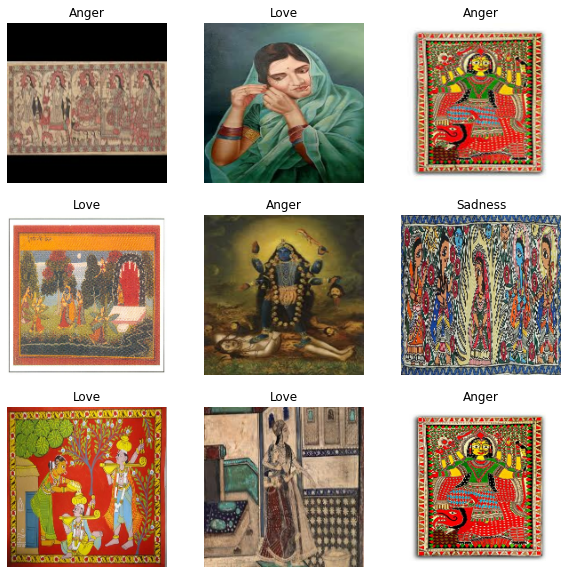

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #print(labels[i].numpy()) 
        if(labels[i][0].numpy() == 1.):
          plt.title("Anger")
        elif(labels[i][1].numpy() == 1.):
          plt.title("Love")
        if(labels[i][2].numpy() == 1.):
          plt.title("Peace")
        if(labels[i][3].numpy() == 1.):
          plt.title("Sadness")

        #plt.title((labels[i].numpy()))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),]
)

Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


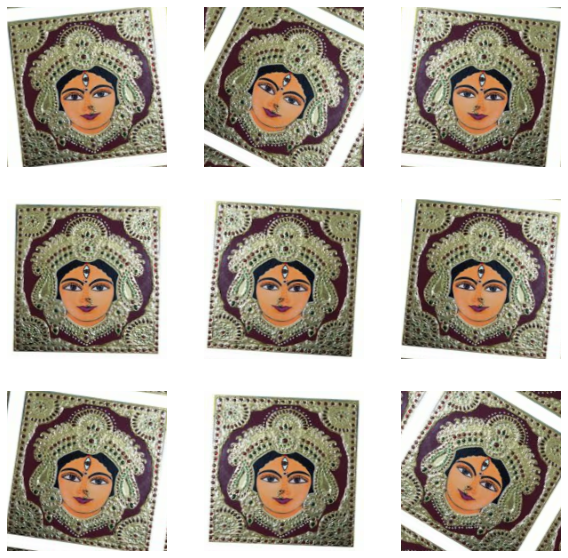

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32) 


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


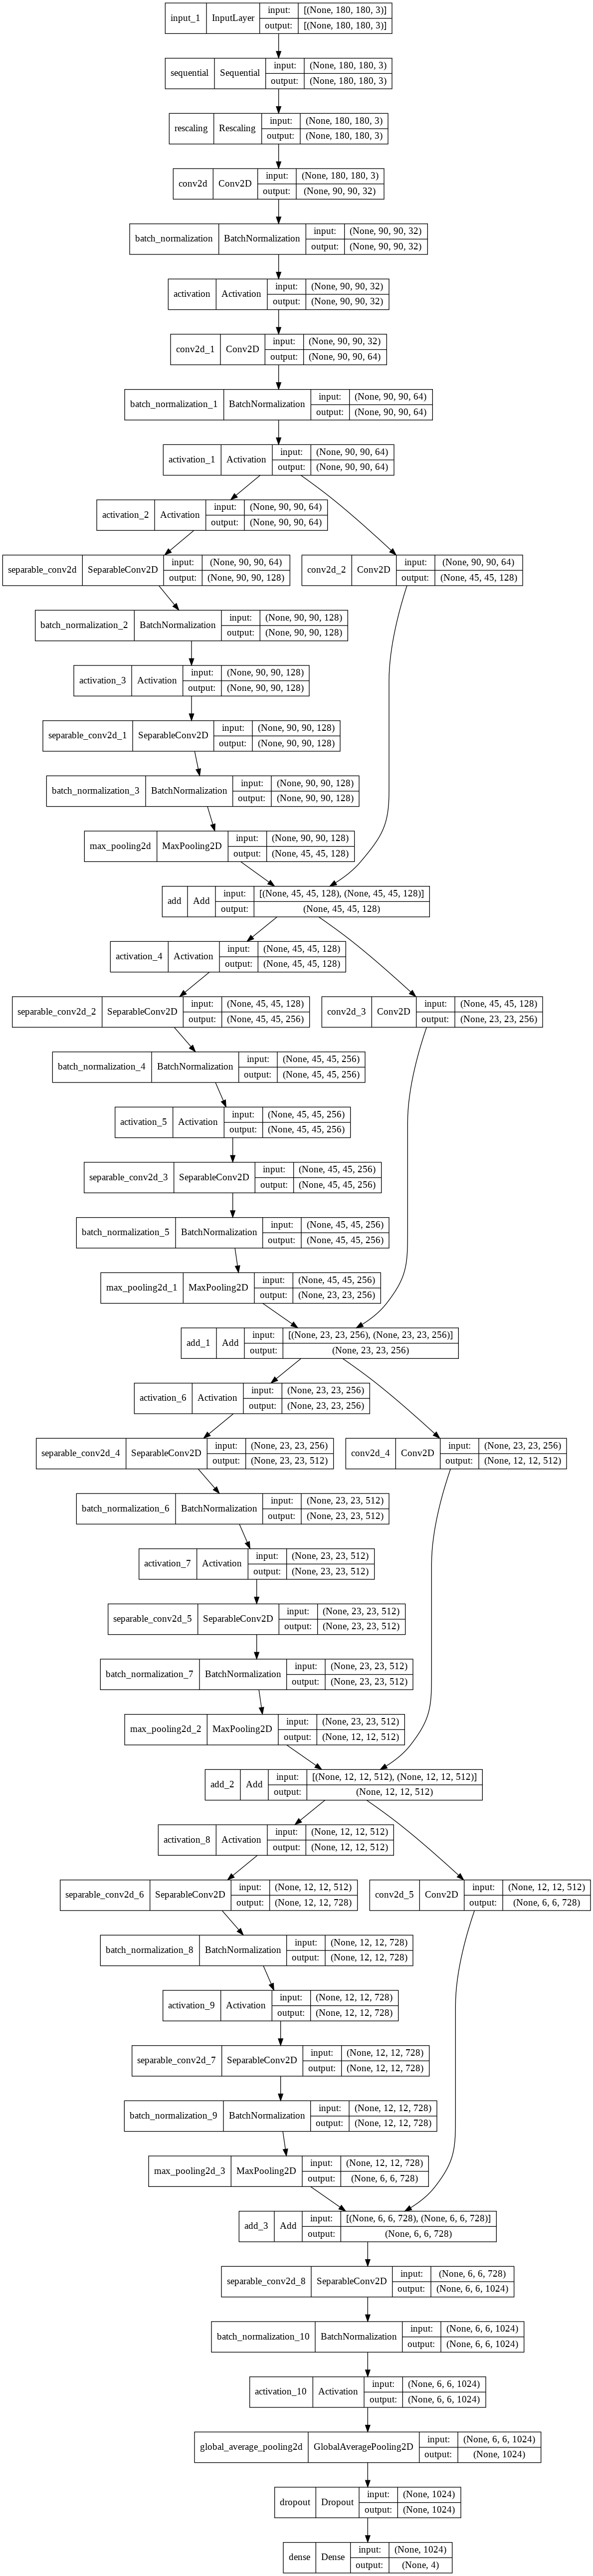

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x) #try removing this normalization
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x) #what other values can you pass to padding
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x) #hyperbole function
    #try from 64->32->16, kernel rn is 3, can take kernel has 2 or 4, strides=2 can be changed to 1 or 3
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x) #can use average pooling

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x) #try less and more than 0.5
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

#hyperparams: activation functions, loss functions, layers, filters, kernel size, data points, epochs

model = make_model(input_shape=image_size + (3,), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 0.2126 - accuracy: 0.9254

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


20/20 [==============================] - 147s 7s/step - loss: 0.2126 - accuracy: 0.9254 - val_loss: 2.3274 - val_accuracy: 0.6306
Epoch 2/50
20/20 [==============================] - 143s 7s/step - loss: 0.1864 - accuracy: 0.9286 - val_loss: 2.2738 - val_accuracy: 0.4650
Epoch 3/50
20/20 [==============================] - 143s 7s/step - loss: 0.1441 - accuracy: 0.9524 - val_loss: 1.4301 - val_accuracy: 0.6815
Epoch 4/50
20/20 [==============================] - 143s 7s/step - loss: 0.1058 - accuracy: 0.9683 - val_loss: 1.2479 - val_accuracy: 0.7134
Epoch 5/50
20/20 [==============================] - 142s 7s/step - loss: 0.0881 - accuracy: 0.9667 - val_loss: 1.4177 - val_accuracy: 0.6306
Epoch 6/50
20/20 [==============================] - 143s 7s/step - loss: 0.1544 - accuracy: 0.9556 - val_loss: 1.3638 - val_accuracy: 0.6497
Epoch 7/50
20/20 [==============================] - 143s 7s/step - loss: 0.1919 - accuracy: 0.9143 - val_loss: 1.3405 - val_accuracy: 0.6943
Epoch 8/50
20/20 [======

We get to ~65% validation accuracy after training for 30 epochs.


5/5 [==============================] - 8s 1s/step - loss: 1.4766 - accuracy: 0.6879


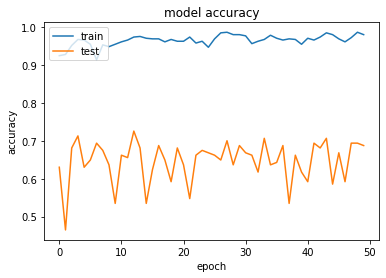

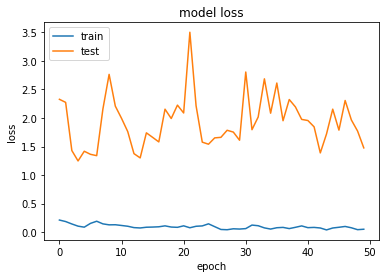

In [ ]:
#PLOTS FOR ACCURACY AND LOSS
(eval_loss, eval_accuracy) = model.evaluate(val_ds, batch_size=batch_size, verbose=1)

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#regularization -> dropout, adaboost algorithm

Normalized confusion matrix


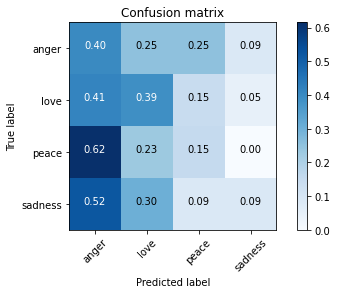

In [ ]:
#confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import sklearn.metrics as metrics
import pandas as pd

#EXTRACTS DATA AND LABELS, WHAT IS THE TYPE?
val_data = val_ds.map(lambda image, label: image)
# for image in val_data.take(1):
#     print(image)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

y_pred = model.predict(val_data) #preds/rounded test_labels
rounded_predictions = np.argmax(y_pred,axis=1) #model.predict_classes(val_data, batch_size=128, verbose=0)
rounded_predictions[1]

rounded_labels=np.argmax(val_labels, axis=1)
rounded_labels[1]

cm = confusion_matrix(rounded_labels, rounded_predictions)
#print(cm)

emotions = ['anger', 'love', 'peace', 'sadness']
classification_metrics = metrics.classification_report(rounded_labels, rounded_predictions, target_names=emotions)

# categorical_test_labels = pd.DataFrame(y_pred).idxmax(axis=1)
# categorical_preds = pd.DataFrame(val_labels).idxmax(axis=1)
#cm= confusion_matrix(rounded_labels, rounded_predictions)

# #To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
   normalize=False,
   title= "Confusion matrix",
   cmap=plt.cm.Blues):
 
  #Add Normalization Option
  #prints pretty confusion metric with normalization option
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
 
#print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i in range (cm.shape[0]):
    for j in range (cm.shape[1]):
  # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')  

plot_confusion_matrix(cm, ['anger', 'love', 'peace', 'sadness'], normalize=True)


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/classifier/Love/Rasa-in-aesthetics-1280x720.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

labels = ["anger", "love", "peace", "sadness"]
print(score)
for i in range(4):
  if (max(score) == score[i]):
      print("This painting depicts", labels[i])
  else:
    continue

[1.8807605e-04 6.5164995e-01 2.7507349e-04 3.4788695e-01]
This painting depicts love
